In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
pip install foolbox==2.4

     |████████████████████████████████| 1.9MB 2.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 163kB 19.2MB/s 
     |████████████████████████████████| 71kB 6.5MB/s 
  Created wheel for foolbox: filename=foolbox-2.4.0-cp36-none-any.whl size=1926223 sha256=aabd612a7b72b6c694fb7fd4bc7cce754b28e64fd90c18c6f3f34444c36b7c75
  Stored in directory: /root/.cache/pip/wheels/ae/5a/11/a5b42761c70dd38c674d889f6ce7edc9867d0262f95de8712b
Successfully built foolbox


In [ ]:
cd '/content/gdrive/My Drive'

/content/gdrive/My Drive


In [ ]:
import os
import sys
import foolbox
import argparse
import tensorflow as tf

from classification_models.keras import Classifiers
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from copy import copy
import time

print(sys.version)
print(tf.__version__)

Using TensorFlow backend.


3.6.9 (default, Jul 17 2020, 12:50:27) 
[GCC 8.4.0]
1.15.2


In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# Train

In [ ]:
histoYK = [[] for i in range(30)]

def loadCIFAR(test=False, train=False) :
    cifar100 = tf.keras.datasets.cifar100
    (x_train, y_train), (x_test, y_test) = cifar100.load_data()
    '''
    (x_train1, y_train), (x_test1, y_test) = cifar100.load_data()
    x_train = x_train1.astype('float32') / 255
    x_test = x_test1.astype('float32') / 255'''

    image, label, labelf = [], [], []
    if test :
        for i in range(len(x_test)) :
            if y_test[i] == 88 : # tigre (88) 
                label.append([0,1])
                image.append(x_test[i])
                labelf.append(1)
            if y_test[i] == 42 and not train : # lion  (42)
                label.append([1,0])
                image.append(x_test[i])
                labelf.append(0)
            if y_test[i] == 90 and train: # train  (90)
                label.append([1,0])
                image.append(x_test[i])
                labelf.append(0)
    else :
        for i in range(len(y_train)) :
            if y_train[i] == 88 : # tigre (88) 
                label.append([0,1])
                labelf.append(1)
                image.append(x_train[i])
            if y_train[i] == 42 and not train: # lion  (42)
                label.append([1,0])
                image.append(x_train[i])
                labelf.append(0)
            if y_train[i] == 90 and train: # train  (90)
                label.append([1,0])
                image.append(x_train[i])
                labelf.append(0)

    image = np.array(image)
    label = np.array(label)
    labelf = np.array(labelf)
    return image, label, labelf

def game(k,i,fks,zks,labelf) :
    global histoYK
    imgs = zks[:,i]
    fMax = fks[0] #Le premier classifieur
    maxZ = 0
    classiNB = 0
    
    for ki in range(k) : # les classifeurs
        actZ = fks[ki].predict(imgs)[0][labelf[i]] 
        if actZ>=maxZ : 
            maxZ=actZ
            fMax = fks[ki]
            classiNB = ki

    histoYK[k-1].append(classiNB)

    imgMin = fMax.predict(imgs)[:,labelf[i]].argmin()
    yki = zks[imgMin][i]

    return yki

def printCPTTime(sec) :
    sec = int(sec)
    if sec <60 :
        print("00:"+str(sec))
    elif sec<3600 : 
        print(str(sec//60)+":"+str(sec%60))
    else :
        reste = sec%3600
        print(str(sec//3600)+":"+str(reste//60)+":"+str(reste%60))
        
def giveTime() :
    return str(time.localtime()[3])+":"+str(time.localtime()[4])

In [ ]:
theClassifieurs = np.array([])
theZk = np.array([])
theYk = np.array([])

def start(kIter=10, nbEpoch=280, batchSize=256, filePath="modelCifar2", TT=False) :
    global theClassifieurs, theZk, theYk
    ResNet18, preprocess_input = Classifiers.get('resnet18')
    if not os.path.exists(filePath):
        os.makedirs(filePath)

    if not os.path.exists(filePath+"/dataset"):
        os.makedirs(filePath+"/dataset")

    # Charge les images
    image, label, labelf = loadCIFAR(train=TT)
    N = len(image)

    # Creer f0
    # f0 = tf.keras.applications.MobileNetV2(input_shape=[32,32,3], include_top=True, classes=2, weights=None) #, weights='imagenet'
    model = ResNet18(input_shape=[32,32,3], include_top=True, classes=2, weights=None)
    optim = tf.compat.v1.train.AdamOptimizer(1e-4)
    loss = tf.keras.losses.MeanSquaredError() #.BinaryCrossentropy(from_logits=True)
    model.compile(optim, loss, metrics=['accuracy'])
    theClassifieurs = np.array([copy(model) for i in range(kIter+1)])

    # Si un f0 existe déjà, le charger sinon en entrainer un
    if os.path.exists(filePath+"/f0") : 
        print(giveTime()+" >>> Load F0")
        theClassifieurs[0].load_weights(filePath+'/f0')
    else :
        print(giveTime()+" >>> Train F0")
        theClassifieurs[0].fit(image, label, epochs=200, batch_size=256)
        theClassifieurs[0].save_weights(filePath+'/f0')

    # Créer Z0
    print(giveTime()+" >>> Create Z0\n\n")
    foolModel = foolbox.models.KerasModel(theClassifieurs[0], bounds=(0, 255))
    attack = foolbox.attacks.GradientSignAttack(foolModel, distance=foolbox.distances.MeanSquaredDistance)
    Z0 = image
    np.save(filePath+"/dataset/Z0", Z0)

    # Créer ensemble des adversaires (et y place Z0)
    theZk = np.array([Z0])
    theYk = np.array([])

    k=1
    while k<=kIter :
        # Générer Zk
        print(giveTime()+" >>> New Iter "+str(k)+"/"+str(kIter))
        print(giveTime()+" >>> Create Z"+str(k)+"")
        foolModel = foolbox.models.KerasModel(theClassifieurs[k-1], bounds=(0, 255))
        attack = foolbox.attacks.GradientSignAttack(foolModel, distance=foolbox.distances.MeanSquaredDistance)

        max_eps = 1
        epss    = 2000
        ZK = attack(image, labelf, epsilons=2000, max_epsilon=max_eps) #, epsilon=0.5 , stepsize=0.05, iterations=200, return_early=True)
        Zk_acc = np.mean(theClassifieurs[k-1].predict(ZK).argmax(axis=-1) == labelf)
        '''
        while Zk_acc > 0.1 :
          max_eps /= 10
          print(giveTime()+" >>> Z"+str(k)+" acc "+str(Zk_acc)+" "+str(max_eps)+" "+str(epss))
          ZK = attack(image, labelf, epsilons=2000, max_epsilon=max_eps) #, epsilon=0.5 , stepsize=0.05, iterations=200, return_early=True)
          newZk_acc = np.mean(theClassifieurs[k-1].predict(ZK).argmax(axis=-1) == labelf)

          if newZk_acc > Zk_acc :
            epss    *= 10
            #max_eps /= 10

          Zk_acc = newZk_acc
        '''
        print(giveTime()+" >>> Z"+str(k)+" acc "+str(Zk_acc))

        theZk = np.concatenate((theZk,[ZK]))
        np.save(filePath+"/dataset/Z"+str(k), ZK)

        # Jouer au jeu pour générer Yk
        print(giveTime()+" >>> Create Y"+str(k)+"")
        YK = np.array([])
        for i in range(N) :
            yki = game(k,i,theClassifieurs,theZk,labelf)

            if YK.size == 0 :
                YK = np.array([yki])
            else :
                YK = np.concatenate((YK,[yki]))
                
        np.save(filePath+"/dataset/Y"+str(k), YK)

        Yk_acc = np.mean(theClassifieurs[k-1].predict(YK).argmax(axis=-1) == labelf)
        print(giveTime()+" >>> Y"+str(k)+" acc (k-1) "+str(Yk_acc))

        # Entraine un nouveau classifieur Fk à partir de Yk
        print(giveTime()+" >>> Train F"+str(k))
        theClassifieurs[k].compile(optim, loss, metrics=['accuracy'])
        theClassifieurs[k].fit(YK, label, epochs=nbEpoch, batch_size=batchSize) #theClassifieurs[k].fit(np.concatenate((image,YK),axis=0), np.concatenate((label,label),axis=0), epochs=nbEpoch, batch_size=batchSize)
        theClassifieurs[k].save_weights(filePath+'/f'+str(k))

        Yk_acc = np.mean(theClassifieurs[k].predict(YK).argmax(axis=-1) == labelf)
        print(giveTime()+" >>> Y"+str(k)+" acc (k) "+str(Yk_acc))

        # Ajoute ce Yk aux autres
        if theYk.size == 0 :
            theYk = np.array([YK])
        else :
            theYk = np.concatenate((theYk,[YK]))

        print("\n\n")
        k+=1

In [ ]:
start(kIter=30, nbEpoch=200, filePath="resnetCifarTT_MINMAX_FGSM2", TT=True) #resnetCifarTT_MINMAX_PGD

In [ ]:
np.save("histoYK_FGSM2", histoYK)

# Test

In [ ]:
ResNet18, preprocess_input = Classifiers.get('resnet18')

# Charge les images
image, label, labelf = loadCIFAR(False,True)
N = len(image)

# Creer f0
model = ResNet18(input_shape=[32,32,3], include_top=True, classes=2, weights=None)
optim = tf.compat.v1.train.AdamOptimizer(1e-4)
loss = tf.keras.losses.MeanSquaredError() #.BinaryCrossentropy(from_logits=True)
model.compile(optim, loss, metrics=['accuracy'])
theClassifieurs = np.array([copy(model) for i in range(30+1)])
theClassifieurs[0].compile(optim, loss, metrics=['accuracy'])

# Pré-train
print(giveTime()+" >>> Train F0")
theClassifieurs[0].fit(image, label, epochs=200, batch_size=256)

# Load Data

In [ ]:
filePath="resnetCifarTT_MINMAX_FGSM2"
maxIter = 30

image, label, labelf = loadCIFAR(train=True)
imageTest, labelTest, labelTestf = loadCIFAR(True,True)

169009152/169001437 [==============================] - 2s 0us/step


In [ ]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [ ]:
def loadDatas(iterMax) :
    global theClassifieurs, theZk, theYk
    ResNet18, preprocess_input = Classifiers.get('resnet18')
    
    f0 = ResNet18(input_shape=[32,32,3], include_top=True, classes=2, weights=None)
    optim = tf.compat.v1.train.AdamOptimizer(1e-4)
    f0.compile(optim, loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy'])
    theClassifieurs = np.array([copy(f0) for i in range(maxIter+1)])
    
    theClassifieurs[0].load_weights(filePath+'/f'+str(0))
    theZk = np.array([np.load(filePath+"/dataset/Z"+str(maxIter)+".npy")])
    theYk = np.array([np.load(filePath+"/dataset/Z"+str(maxIter)+".npy")])
    
    for i in range(1,iterMax+1) : 
        theClassifieurs[i].load_weights(filePath+'/f'+str(i))
        theZk = np.concatenate((theZk,np.array([np.load(filePath+"/dataset/Z"+str(i)+".npy")])))
        theYk = np.concatenate((theYk,np.array([np.load(filePath+"/dataset/Y"+str(i)+".npy")])))

In [ ]:
loadDatas(maxIter)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



/tensorflow-1.15.2/python3.6/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '
/tensorflow-1.15.2/python3.6/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## Distance

In [ ]:
dest_YK, dest_ZK = [], []
Zfinal = np.load(filePath+"/dataset/Z"+str(maxIter)+".npy")

Z0  = np.load(filePath+"/dataset/Z0.npy")
eqm = tf.keras.losses.MSE(image/255,Z0/255)
dest_ZK.append(sess.run(eqm).mean())

for k in range(0,maxIter) :
  Yk = np.load(filePath+"/dataset/Y"+str(k+1)+".npy")
  eqm  = tf.keras.losses.MSE(image/255,Yk/255)
  dest_YK.append(sess.run(eqm).mean())

  Zk = np.load(filePath+"/dataset/Z"+str(k+1)+".npy")
  eqm  = tf.keras.losses.MSE(image/255,Zk/255)
  dest_ZK.append(sess.run(eqm).mean())

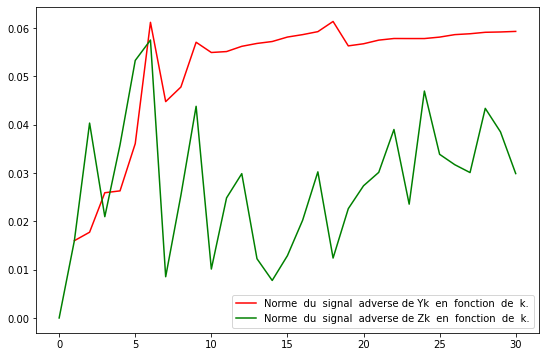

In [ ]:
plt.rcParams["figure.figsize"] = (9,6)
plt.plot([i+1 for i in range(maxIter)], dest_YK, 'r', label="Norme  du  signal  adverse de Yk  en  fonction  de  k.")
plt.plot([i for i in range(maxIter+1)], dest_ZK, 'g', label="Norme  du  signal  adverse de Zk  en  fonction  de  k.")
plt.legend()

In [ ]:
dest_YK[10:16]

[0.055128127, 0.056212276, 0.056809224, 0.057206534, 0.05812963, 0.058632523]

In [ ]:
eps = 0.5

a = time.time()
print(eps)
all_PGD = np.array([])
for i in range(maxIter+1) :
    foolModel = foolbox.models.KerasModel(theClassifieurs[i], bounds=(0, 255))
    attack = foolbox.attacks.GradientSignAttack(foolModel, distance=foolbox.distances.MeanSquaredDistance)
    PGD = attack(imageTest, labelTestf, epsilons=2000, max_epsilon=5)

    if all_PGD.size == 0 :
        all_PGD = np.array([np.copy(PGD)])
    else :
        all_PGD = np.concatenate((all_PGD,[np.copy(PGD)]))

b = time.time()
printCPTTime(b-a)

In [ ]:
#np.save("eps_FGSM_test", eps_PGD)
# eps_PGD = np.load("eps_FGSM_test.npy")

In [ ]:
#np.save("histoYK_FGSM", histoYK)
#histoYK = np.load("histoYK.npy")

In [ ]:
len(histoYK[0])

0

In [ ]:
eps_better_PGD = np.array([])
better_PGD = np.array([])

a = time.time()

histoYK = [[] for i in range(maxIter)]
theZk = np.array([all_PGD[0]])
for k in range(1,maxIter+1) : 
  print(k)
  theZk = np.concatenate((theZk,[all_PGD[k]]))
  better_PGD = np.array([])

  for i in range(len(imageTest)) :
      better_image = game(k,i,theClassifieurs,all_PGD,labelTestf)

      if better_PGD.size == 0 :
          better_PGD = np.array([np.copy(better_image)])
      else :
          better_PGD = np.concatenate((better_PGD,[np.copy(better_image)]))

  print(better_PGD.shape)
  if eps_better_PGD.size == 0 :
      eps_better_PGD = np.array([np.copy(better_PGD)])
  else :
      eps_better_PGD = np.concatenate((eps_better_PGD,[np.copy(better_PGD)]))

b = time.time()
printCPTTime(b-a) 

In [ ]:
eps_better_PGD.shape

(30, 200, 32, 32, 3)

In [ ]:
predictN, predictT, predictYT, predictNT = [], [], [], []
predictY, predictZ, predictZF = [], [0], []
Zfinal = np.load(filePath+"/dataset/Z"+str(maxIter)+".npy")
for k in range(0,maxIter+1) :    
    predictNT.append(np.mean(theClassifieurs[k].predict(imageTest).argmax(axis=-1) == labelTestf))
    predictN.append(np.mean(theClassifieurs[k].predict(image).argmax(axis=-1) == labelf))
    
    if k == 0 :
        predictY.append(0)
        predictT.append(predictNT[k])
    else :
        Yk = np.load(filePath+"/dataset/Y"+str(k)+".npy")
        print('f'+str(k)+' load')
        predictY.append(np.mean(theClassifieurs[k].predict(Yk).argmax(axis=-1) == labelf))
    
        Zk = np.load(filePath+"/dataset/Z"+str(k)+".npy")
        print('Z'+str(k)+' load \n')
        predictZ.append(np.mean(theClassifieurs[k-1].predict(Zk).argmax(axis=-1) == labelf))
        predictYT.append(np.mean(theClassifieurs[k].predict(eps_better_PGD[k-1]).argmax(axis=-1) == labelTestf))
        #predictT.append((predictNT[k]+predictYT[k-1])/2)

    predictZF.append(np.mean(theClassifieurs[k].predict(Zfinal).argmax(axis=-1) == labelf))

f1 load
Z1 load 

f2 load
Z2 load 

f3 load
Z3 load 

f4 load
Z4 load 

f5 load
Z5 load 

f6 load
Z6 load 

f7 load
Z7 load 

f8 load
Z8 load 

f9 load
Z9 load 

f10 load
Z10 load 

f11 load
Z11 load 

f12 load
Z12 load 

f13 load
Z13 load 

f14 load
Z14 load 

f15 load
Z15 load 

f16 load
Z16 load 

f17 load
Z17 load 

f18 load
Z18 load 

f19 load
Z19 load 

f20 load
Z20 load 

f21 load
Z21 load 

f22 load
Z22 load 

f23 load
Z23 load 

f24 load
Z24 load 

f25 load
Z25 load 

f26 load
Z26 load 

f27 load
Z27 load 

f28 load
Z28 load 

f29 load
Z29 load 

f30 load
Z30 load 



In [ ]:
theClassifieurs[0].predict(np.array(all_PGD)[:,1])[0][labelf[i]]

0.4960511

In [ ]:
## Distortion non entrainer
eqm  = tf.keras.losses.MSE(imageTest/255,all_PGD[0]/255)
print(sess.run(eqm).mean())

0.012297771


In [ ]:
## Distortion entrainer
eqm  = tf.keras.losses.MSE(imageTest/255,all_PGD[maxIter]/255)
print(sess.run(eqm).mean())

0.043812186


In [ ]:
## Joue Jeu
eqm  = tf.keras.losses.MSE(imageTest/255,eps_better_PGD[4]/255)
max_eqm  = np.mean(sess.run(eqm))
eqm_std  = np.std(sess.run(eqm))
print(max_eqm)

0.042111732


# Plot

In [ ]:
histoYK = np.load("histoYK_FGSM2.npy")

In [ ]:
 #data2 = [[0 for i in range(maxIter)] for j in range(maxIter)]
data = [[0 for i in range(maxIter)] for j in range(1)]
for i in range(maxIter) :
  print(i)
  x = np.array(histoYK[i])
  y = np.bincount(x)
  ii = np.nonzero(y)[0]
  d = dict()
  for j in range(0,i+1) :
    try :
      data[j][i] = y[j]
    except :
      data[j][i] = 0

In [ ]:
plt.rcParams["figure.figsize"] = (20,6)
X = np.arange(1,maxIter+1)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
allColors = ["b","g","r","y","orange","brown","mediumorchid","dodgerblue","forestgreen","mediumblue","aquamarine","darkviolet"]
for i in range(maxIter) :
    ax.bar(X + 1/maxIter*i, data[i], color = allColors[(i)%12], width = 1/maxIter)

In [ ]:
plt.rcParams["figure.figsize"] = (9,6) #(8,5)
plt.plot([i for i in range(maxIter+1)], predictN, 'b', label="Prediction Image", dashes=[3, 4])
plt.plot([i for i in range(maxIter+1)], predictNT, 'gold', label="Prediction Image Naturel Test en fonction de K", dashes=[3, 2])
plt.plot([i for i in range(1,maxIter+1)], predictYT, 'red', label="Prediction Image YTest en fonction de K", dashes=[6, 2])
plt.plot([i for i in range(1,maxIter+1)], predictY[1:], 'g', label="Prediction Yk par Fk en fonction de K", dashes=[6, 2])
plt.plot([i for i in range(maxIter+1)], predictZ, 'y', label="Prediction Zk  par Fk-1 en fonction de K", dashes=[3, 2])
#plt.plot([i for i in range(maxIter+1)], predictZF, 'purple', label="Prediction de Zk par Zfinal en fonction de K")
#plt.plot([i for i in range(maxIter+1)], [0.5 for i in range(maxIter+1)], 'orange', label="Y=0.5")
plt.legend()
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,1.1))

# Show Image Exemple

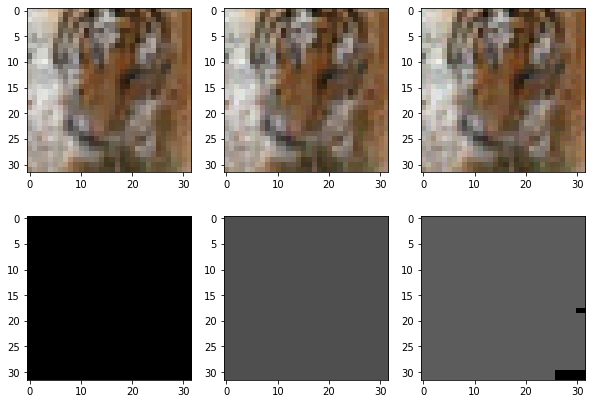

In [ ]:
imgNum, plt.rcParams["figure.figsize"] = 10, (10,7)

if theClassifieurs[-1].predict(image[imgNum:imgNum+1]).argmax(axis=-1) != labelf[imgNum:imgNum+1] : 
  print("diff")

plt.subplot(2, 3, 1)
plt.imshow(image[imgNum])

foolModel = foolbox.models.KerasModel(theClassifieurs[0], bounds=(0, 255))
attack = foolbox.attacks.GradientSignAttack(foolModel, distance=foolbox.distances.MeanSquaredDistance)
ad0 = attack(image[imgNum:imgNum+1], labelf[imgNum:imgNum+1], epsilons=2000, max_epsilon=1)
plt.subplot(2, 3, 2)
plt.imshow(np.asarray(ad0[0], dtype=int))

foolModel = foolbox.models.KerasModel(theClassifieurs[maxIter], bounds=(0, 255))
attack = foolbox.attacks.GradientSignAttack(foolModel, distance=foolbox.distances.MeanSquaredDistance)
adf = attack(image[imgNum:imgNum+1], labelf[imgNum:imgNum+1], epsilons=2000, max_epsilon=1)
plt.subplot(2, 3, 3)
plt.imshow(np.asarray(adf[0], dtype=int))

plt.subplot(2, 3, 4)
plt.imshow(np.absolute(image[imgNum] - image[imgNum]))

diff1 = np.absolute(image[imgNum] - ad0)
diff1 = (diff1)**(1/2)
mi, ma = np.min(diff1[0]), np.max(diff1[0])
#diff1 = 255*(diff1[0]-mi)/(ma-mi)
plt.subplot(2, 3, 5)
plt.imshow(np.asarray(diff1[0]*50, dtype=int))

diff2 = np.absolute(image[imgNum] - adf)
diff2 = (diff2)**(1/2)
mi, ma = np.min(diff2[0]), np.max(diff2[0])
#diff2 = 255*(diff2[0]-mi)/(ma-mi)
plt.subplot(2, 3, 6)
plt.imshow(np.asarray(diff2[0]*50, dtype=int)) #diff2[0]*10

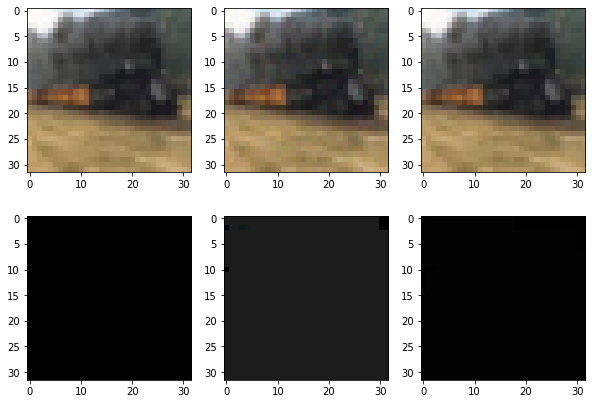

In [ ]:
imgNum, plt.rcParams["figure.figsize"] = 1, (10,7)

if theClassifieurs[-1].predict(image[imgNum:imgNum+1]).argmax(axis=-1) != labelf[imgNum:imgNum+1] : 
  print("diff")

plt.subplot(2, 3, 1)
plt.imshow(image[imgNum])

foolModel = foolbox.models.KerasModel(theClassifieurs[0], bounds=(0, 255))
attack = foolbox.attacks.GradientSignAttack(foolModel, distance=foolbox.distances.MeanSquaredDistance)
ad0 = attack(image[imgNum:imgNum+1], labelf[imgNum:imgNum+1], epsilons=2000, max_epsilon=1)
plt.subplot(2, 3, 2)
plt.imshow(np.asarray(ad0[0], dtype=int))

foolModel = foolbox.models.KerasModel(theClassifieurs[maxIter], bounds=(0, 255))
attack = foolbox.attacks.GradientSignAttack(foolModel, distance=foolbox.distances.MeanSquaredDistance)
adf = attack(image[imgNum:imgNum+1], labelf[imgNum:imgNum+1], epsilons=2000, max_epsilon=1)
plt.subplot(2, 3, 3)
plt.imshow(np.asarray(adf[0], dtype=int))

plt.subplot(2, 3, 4)
plt.imshow(np.absolute(image[imgNum] - image[imgNum]))

diff1 = np.absolute(image[imgNum] - ad0)
mi, ma = np.min(diff1[0]), np.max(diff1[0])
#diff1 = 255*(diff1[0]-mi)/(ma-mi)
plt.subplot(2, 3, 5)
plt.imshow(np.asarray(diff1[0]*10, dtype=int))

diff2 = np.absolute(image[imgNum] - adf)
mi, ma = np.min(diff2[0]), np.max(diff2[0])
#diff2 = 255*(diff2[0]-mi)/(ma-mi)
plt.subplot(2, 3, 6)
plt.imshow(np.asarray(diff2[0]*10, dtype=int)) #diff2[0]*10

In [ ]:
imgNum, plt.rcParams["figure.figsize"] = 11, (10,7)

tab = []

for i in range(100) :
  if theClassifieurs[0].predict(image[i:i+1]).argmax(axis=-1) != labelf[i:i+1] : 
    print(str(i)+" : 0")

  if theClassifieurs[-1].predict(image[i:i+1]).argmax(axis=-1) != labelf[i:i+1] : 
    print(str(i)+" : 30")

  foolModel = foolbox.models.KerasModel(theClassifieurs[-1], bounds=(0, 255))
  attack = foolbox.attacks.GradientSignAttack(foolModel, distance=foolbox.distances.MeanSquaredDistance)
  ad0 = attack(image[i:i+1], labelf[i:i+1], epsilons=2000, max_epsilon=1)
  eqm  = tf.keras.losses.MSE(image[i:i+1]/255,ad0/255)
  tab.append(sess.run(eqm).mean())

In [ ]:
result_PGD = list(map(np.mean,sess.run([tf.keras.losses.MSE(imageTest/255,all_PGD[i]/255) for i in range(maxIter+1)])))
result_STD = list(map(np.std ,sess.run([tf.keras.losses.MSE(imageTest/255,all_PGD[i]/255) for i in range(maxIter+1)])))

error_PGD  = [np.mean(theClassifieurs[i].predict(all_PGD[i]).argmax(axis=-1) == labelTestf) for i in range(maxIter+1)]
error_STD  = [np.std(theClassifieurs[i].predict(all_PGD[i]).argmax(axis=-1) == labelTestf) for i in range(maxIter+1)]

In [ ]:
plt.plot([i for i in range(maxIter+1)], result_PGD, 'g', label="Norme du signal adverse d'une attaque FGSM au classifieur k en fonction de k")
#plt.errorbar([i for i in range(maxIter+1)], result_PGD, yerr=result_STD, linestyle='None', capsize=3)
#plt.plot([i for i in range(maxIter+1)], [max_eqm for i in range(maxIter+1)], 'b', label="Y="+str(max_eqm)+" moyenne des distance avec le MinMax")
#plt.errorbar([i for i in range(maxIter+1)], [max_eqm for i in range(maxIter+1)], yerr=[eqm_std for i in range(maxIter+1)], fmt='.r', linestyle='None', capsize=3)
plt.legend()

In [ ]:
plt.plot([i for i in range(maxIter+1)], [max_eqm for i in range(maxIter+1)], 'cyan', label="Y="+str(max_eqm))
#plt.errorbar([i for i in range(maxIter+1)], [max_eqm for i in range(maxIter+1)], yerr=[sess.run(eqm).std() for i in range(maxIter+1)], linestyle='None', capsize=3)
plt.legend()

In [ ]:
plt.plot([i for i in range(maxIter+1)], error_PGD, 'g', label="Accuracy d'une attaque en fonction du classifieur k")
plt.plot([i for i in range(maxIter+1)], [np.mean(theClassifieurs[i].predict(imageTest).argmax(axis=-1) == labelTestf) for i in range(maxIter+1)], 'k', label="Accuracy des images de tests en fonction du classifieur k")
plt.plot([i for i in range(maxIter+1)], [np.mean(theClassifieurs[i].predict(image).argmax(axis=-1) == labelf) for i in range(maxIter+1)], 'm', label="Accuracy des image de train en fonction du classifieur k")
#plt.errorbar([i for i in range(maxIter+1)], error_PGD, yerr=error_STD, linestyle='None', capsize=3)
plt.legend()
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,1.1))

In [ ]:
eqm  = list(map(np.mean,sess.run(tf.keras.losses.MSE(imageTest/255,all_PGD[maxIter]/255))))
err = theClassifieurs[maxIter].predict(all_PGD[maxIter])
err = [err[i][labelTestf[i]] for i in range(200)]
plt.plot(eqm, err, '.', label="Distance (L2 Norm)")